In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

from sklearn.decomposition import PCA

In [2]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]

def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'


In [3]:
all_df = pd.concat([esc_df, cnc_df], axis=0)



In [4]:
esc_median_map = np.median(esc_maps_interp, axis=0)
cnc_median_map = np.median(cnc_maps_interp, axis=0)

In [5]:
esc_median_map_pca = pca.transform(esc_median_map.reshape(1, -1))
cnc_median_map_pca = pca.transform(cnc_median_map.reshape(1, -1))

In [6]:
esc_med_df = pd.DataFrame(esc_median_map_pca, columns=['PC1', 'PC2'])
esc_med_df['label'] = 'ESC median'
cnc_med_df = pd.DataFrame(cnc_median_map_pca, columns=['PC1', 'PC2'])
cnc_med_df['label'] = 'CNC median'

In [7]:
all_df = pd.concat([all_df, esc_med_df, cnc_med_df], axis=0)

In [8]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240812/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

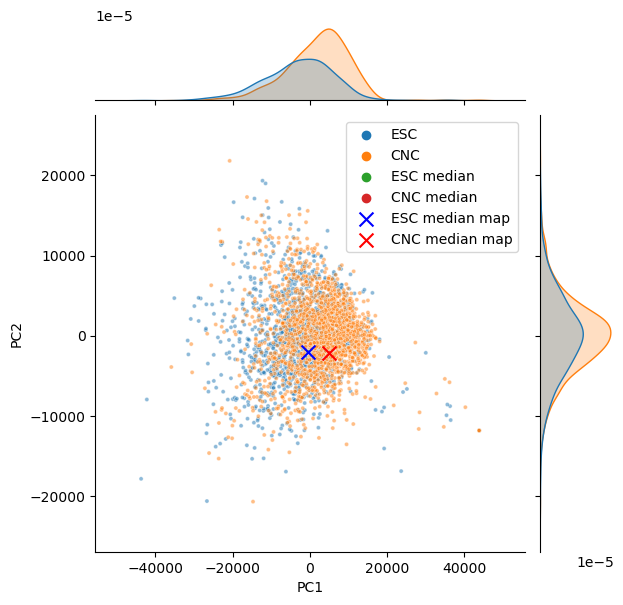

In [9]:
sns.jointplot(data=all_df, x='PC1', y='PC2', hue='label', marker='.', alpha=0.5)
plt.scatter(esc_med_df['PC1'], esc_med_df['PC2'], color='blue', marker='x', s=100, label='ESC median map')
plt.scatter(cnc_med_df['PC1'], cnc_med_df['PC2'], color='red', marker='x', s=100, label='CNC median map')
plt.legend()
plt.savefig(os.path.join(save_dir, 'pca_maps.png'))

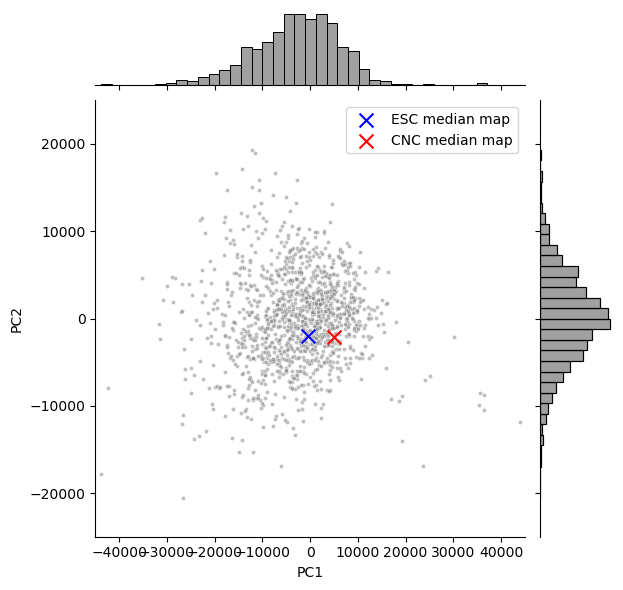

In [10]:
sns.jointplot(data=esc_df, x='PC1', y='PC2', color='gray', marker='.', alpha=0.5)
plt.scatter(esc_med_df['PC1'], esc_med_df['PC2'], color='blue', marker='x', s=100, label='ESC median map')
plt.scatter(cnc_med_df['PC1'], cnc_med_df['PC2'], color='red', marker='x', s=100, label='CNC median map')
plt.legend()
plt.xlim([-45000, 45000])
plt.ylim([-25000, 25000])
plt.savefig(os.path.join(save_dir, 'pca_maps_esc.png'))

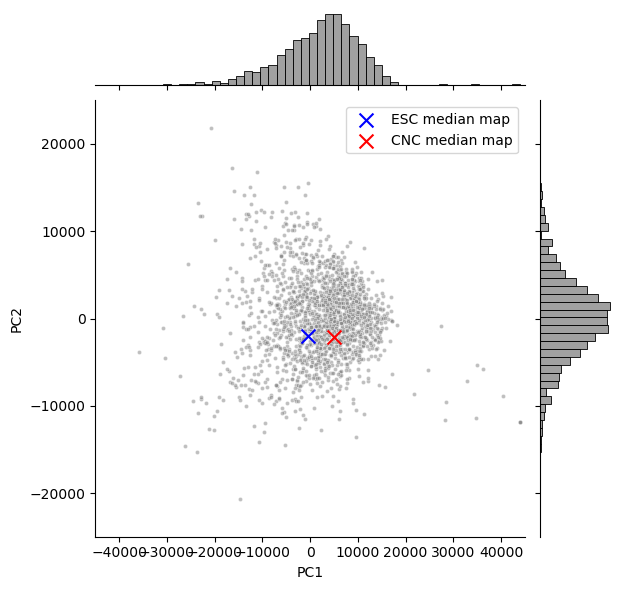

In [11]:
sns.jointplot(data=cnc_df, x='PC1', y='PC2', color='gray', marker='.', alpha=0.5)
plt.scatter(esc_med_df['PC1'], esc_med_df['PC2'], color='blue', marker='x', s=100, label='ESC median map')
plt.scatter(cnc_med_df['PC1'], cnc_med_df['PC2'], color='red', marker='x', s=100, label='CNC median map')
plt.legend()
plt.xlim([-45000, 45000])
plt.ylim([-25000, 25000])
plt.savefig(os.path.join(save_dir, 'pca_maps_cnc.png'))

In [12]:
# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
l = 0.01
u = 1-0.01

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)

pc1_grid = np.linspace(pc1_l, pc1_u, 50)
pc2_grid = np.linspace(pc2_l, pc2_u, 50)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)

metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])

In [13]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

In [14]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240809_WeightMCMC_PCA_metastructures_var'

In [15]:
# List all folders in the directory
folders = [f for f in os.listdir(common_dir) if os.path.isdir(os.path.join(common_dir, f))]

In [16]:
lw_dict = {}
for f in folders:
    dir = os.path.join(common_dir, f)
    stan_directory_esc = os.path.join(dir, 'ESC/stan_output')
    stan_directory_cnc = os.path.join(dir, 'CNC/stan_output')
    stan_directory_all = os.path.join(dir, 'all/stan_output')
    
    esc_log_weights = load_weights(stan_directory_esc, 2500)
    cnc_log_weights = load_weights(stan_directory_cnc, 2500)
    # all_log_weights = load_weights(stan_directory_all, 2500)  
    
    lw_dict[f] = {'ESC': esc_log_weights, 'CNC': cnc_log_weights}
    
    

['20240715_WeightOptimization-20240809164136_1.csv', '20240715_WeightOptimization-20240809164136_2.csv', '20240715_WeightOptimization-20240809164136_3.csv', '20240715_WeightOptimization-20240809164136_4.csv']
['20240715_WeightOptimization-20240809164735_1.csv', '20240715_WeightOptimization-20240809164735_2.csv', '20240715_WeightOptimization-20240809164735_3.csv', '20240715_WeightOptimization-20240809164735_4.csv']
['20240715_WeightOptimization-20240814202640_1.csv', '20240715_WeightOptimization-20240814202640_2.csv', '20240715_WeightOptimization-20240814202640_3.csv', '20240715_WeightOptimization-20240814202640_4.csv']
['20240715_WeightOptimization-20240814203008_1.csv', '20240715_WeightOptimization-20240814203008_2.csv', '20240715_WeightOptimization-20240814203008_3.csv', '20240715_WeightOptimization-20240814203008_4.csv']
['20240715_WeightOptimization-20240809153450_1.csv', '20240715_WeightOptimization-20240809153450_2.csv', '20240715_WeightOptimization-20240809153450_3.csv', '202407

In [17]:
df_dict = {}
for f in lw_dict:
    esc_weights = lw_dict[f]['ESC']
    cnc_weights = lw_dict[f]['CNC']
    
    esc_weights = np.mean(np.exp(np.array(esc_weights)), axis=(0, 1))
    cnc_weights = np.mean(np.exp(np.array(cnc_weights)), axis=(0, 1))
    
    esc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values,  
                               'weight': esc_weights})
    esc_weights_df['label'] = 'ESC'
    cnc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                                'PC2': pc1_pc2_df['PC1'].values, 
                                'weight': cnc_weights})
    cnc_weights_df['label'] = 'CNC'
    
    df_dict[f] = {}
    df_dict[f]['ESC'] = esc_weights_df
    df_dict[f]['CNC'] = cnc_weights_df
        

In [18]:
df_dict['var_10000.0']['ESC']

,PC1,PC2,weight,label
0,-24850.715622,-24850.715622,0.000263,ESC
1,-24850.715622,-24850.715622,0.000264,ESC
2,-24850.715622,-24850.715622,0.000269,ESC
3,-24850.715622,-24850.715622,0.000268,ESC
4,-24850.715622,-24850.715622,0.000271,ESC
...,...,...,...,...
2495,17071.828176,17071.828176,0.000537,ESC
2496,17071.828176,17071.828176,0.000539,ESC
2497,17071.828176,17071.828176,0.000268,ESC
2498,17071.828176,17071.828176,0.000270,ESC


In [19]:
df_dict['var_0.1']['ESC']

,PC1,PC2,weight,label
0,-24850.715622,-24850.715622,0.000272,ESC
1,-24850.715622,-24850.715622,0.000272,ESC
2,-24850.715622,-24850.715622,0.000272,ESC
3,-24850.715622,-24850.715622,0.000274,ESC
4,-24850.715622,-24850.715622,0.000267,ESC
...,...,...,...,...
2495,17071.828176,17071.828176,0.000539,ESC
2496,17071.828176,17071.828176,0.000540,ESC
2497,17071.828176,17071.828176,0.000271,ESC
2498,17071.828176,17071.828176,0.000266,ESC


In [20]:
import matplotlib

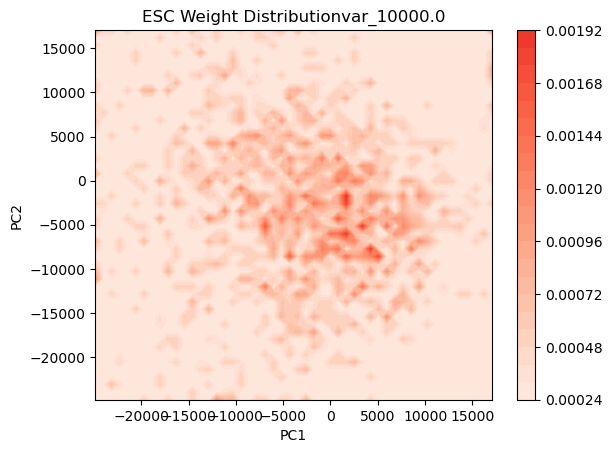

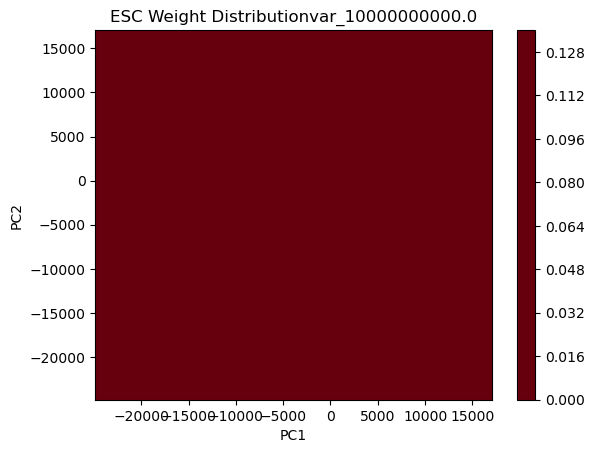

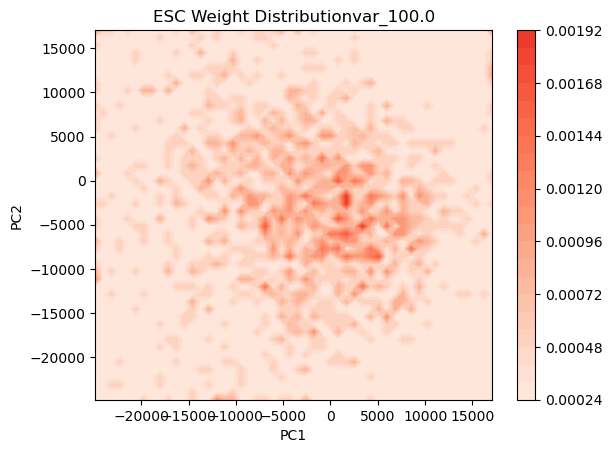

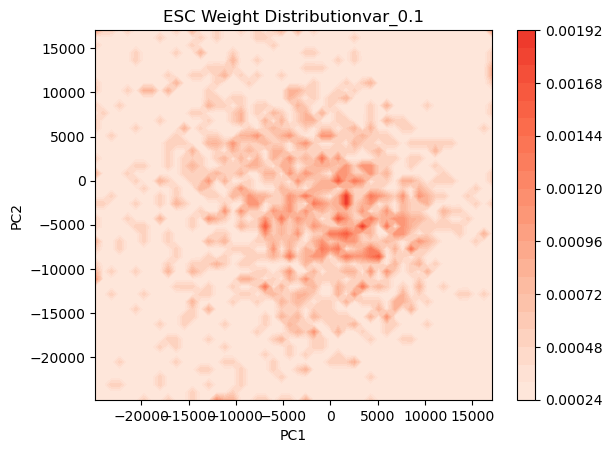

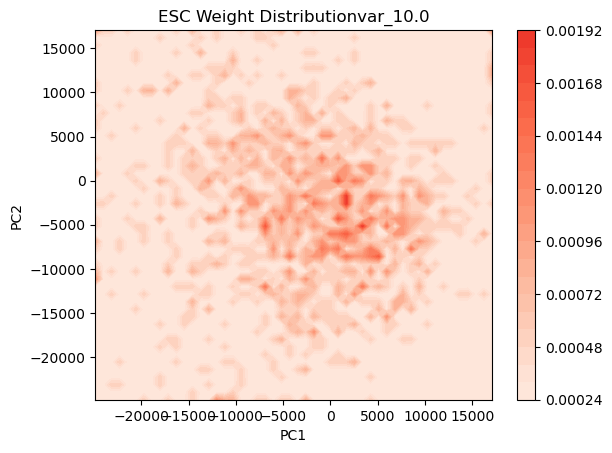

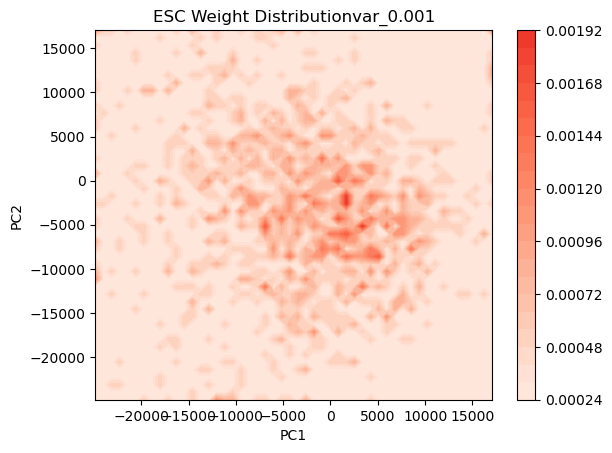

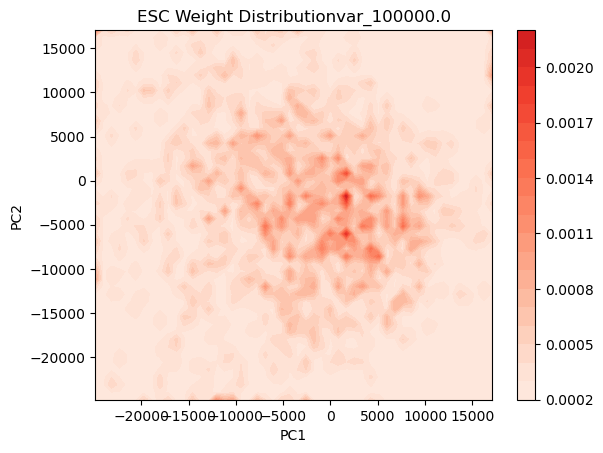

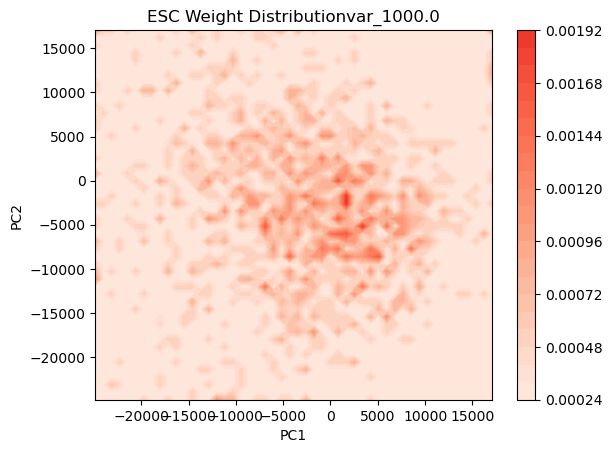

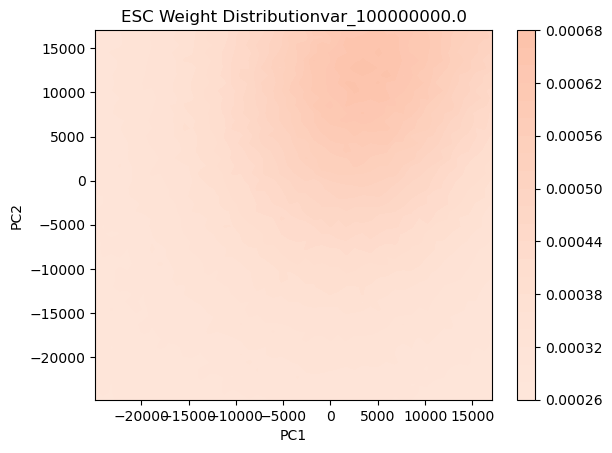

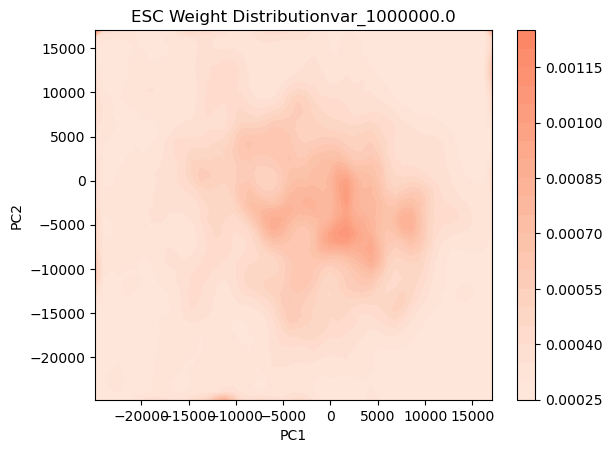

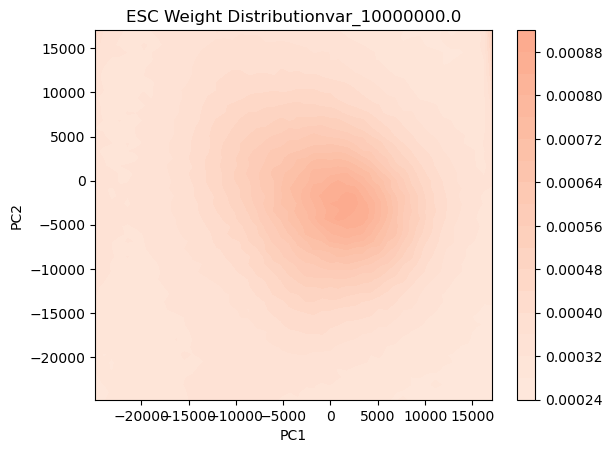

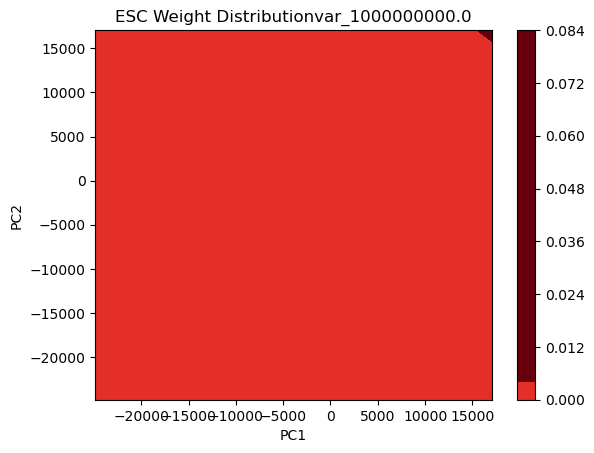

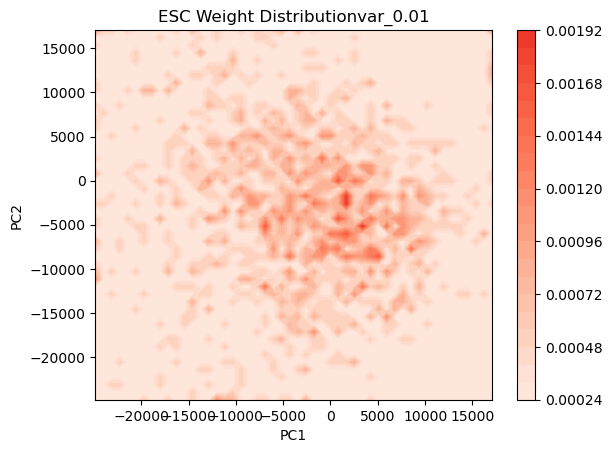

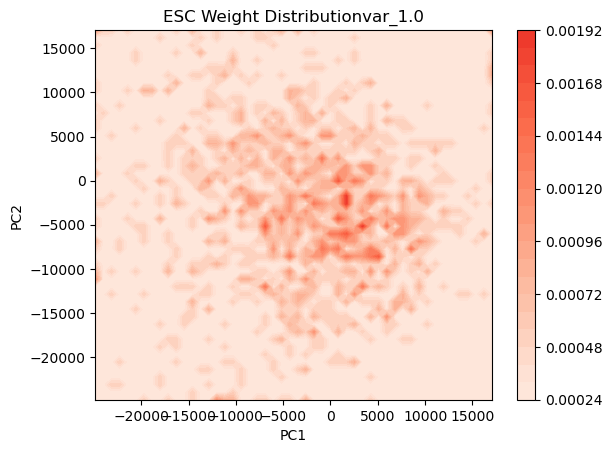

In [21]:
for f in df_dict:
    norm = matplotlib.colors.Normalize(vmin=0, vmax=0.003)
    esc_weights_df = df_dict[f]['ESC']
    fig, ax = plt.subplots()
    contour = ax.contourf(esc_weights_df['PC1'].unique(), esc_weights_df['PC2'].unique(), 
                esc_weights_df['weight'].values.reshape(50, 50).T,
                norm=norm, levels=20, cmap='Reds')
    fig.colorbar(contour, ax=ax)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('ESC Weight Distribution' + f)
    # ax.set_xticks(rotation=45)
    fig.savefig(os.path.join(save_dir, 'esc_weight_distribution_large_{}.png'.format(f)), dpi=300, bbox_inches='tight')

/tmp/ipykernel_58799/1936598419.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.round(esc_weights_df['PC1'].unique(), 0), rotation=45)
/tmp/ipykernel_58799/1936598419.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=np.round(esc_weights_df['PC2'].unique(), 0))


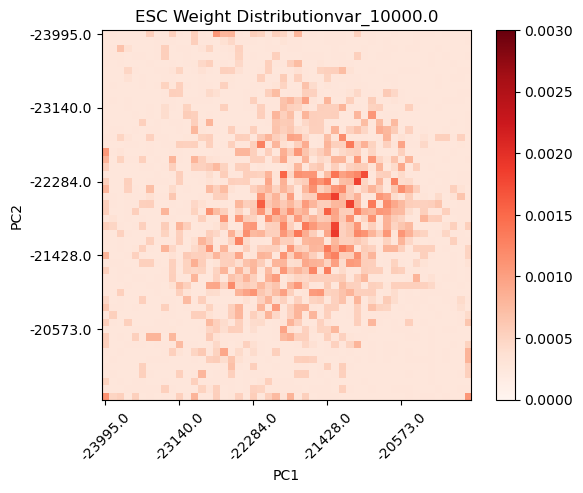

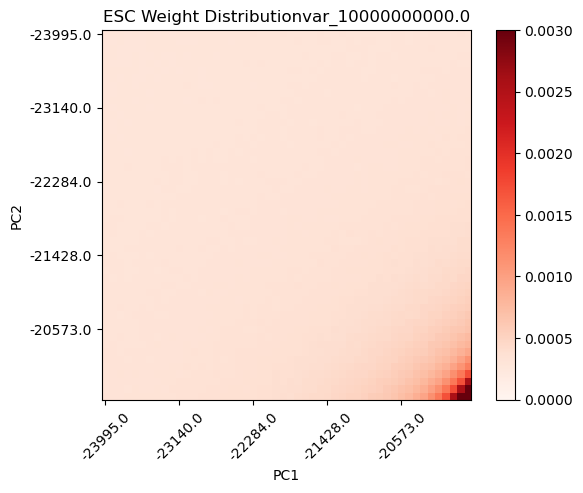

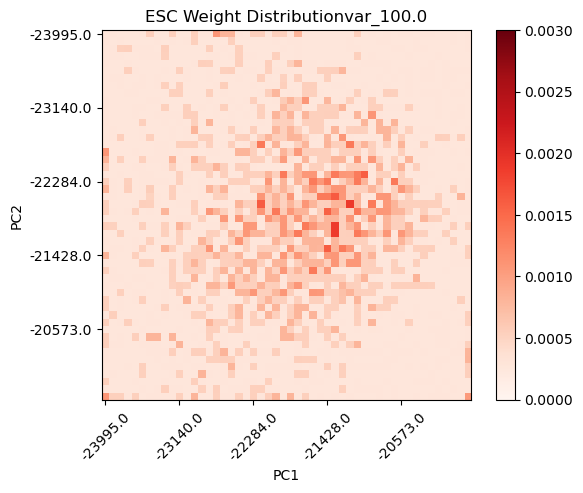

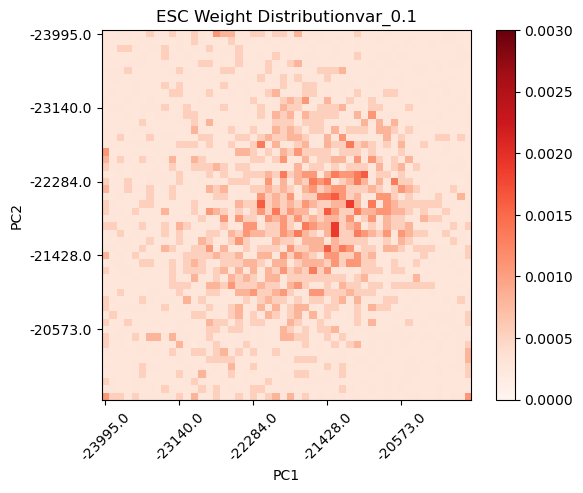

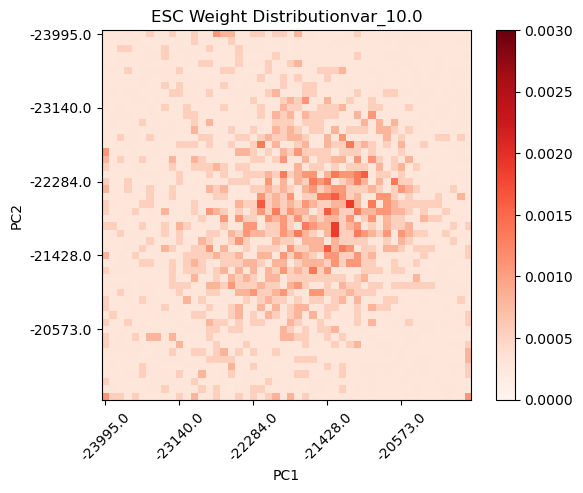

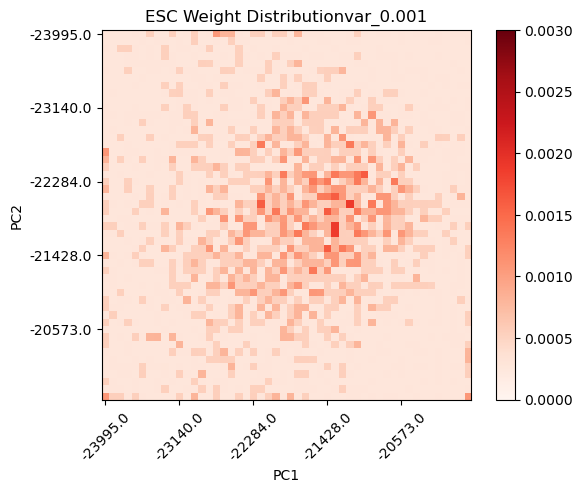

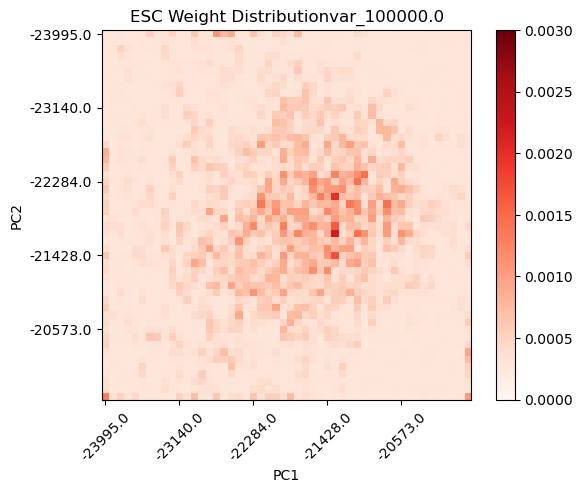

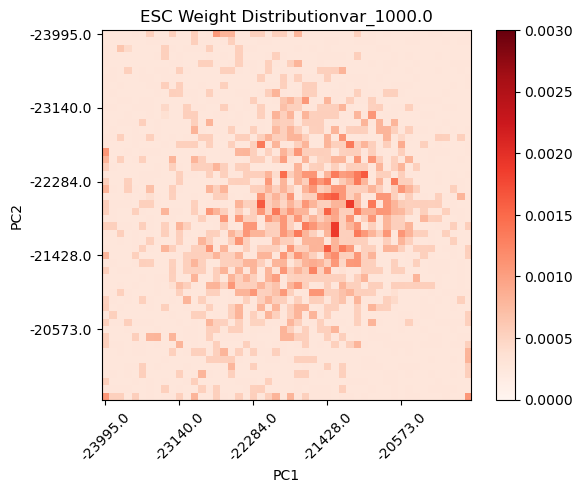

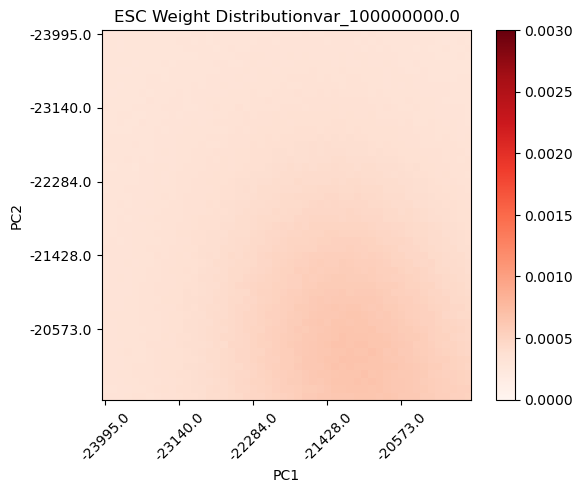

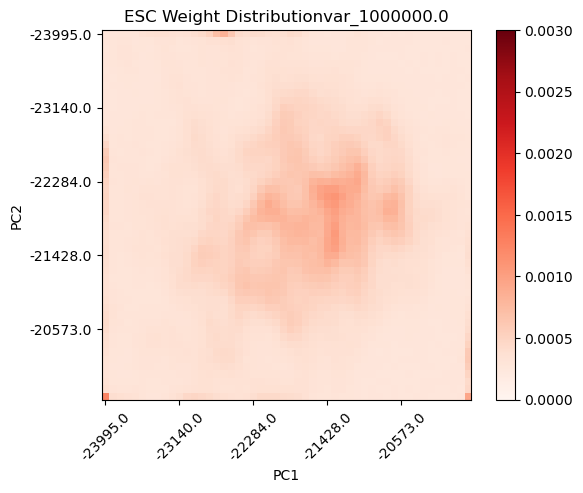

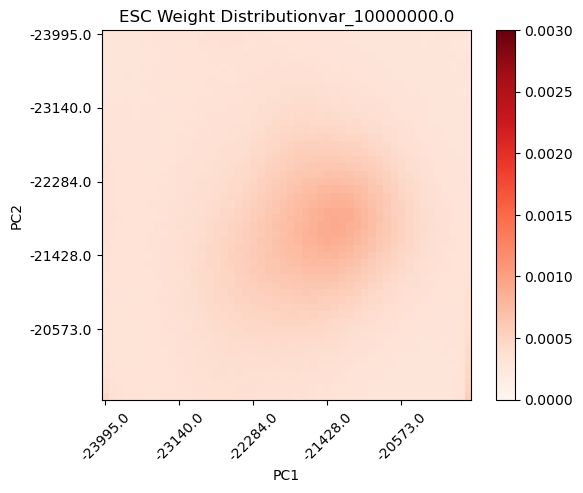

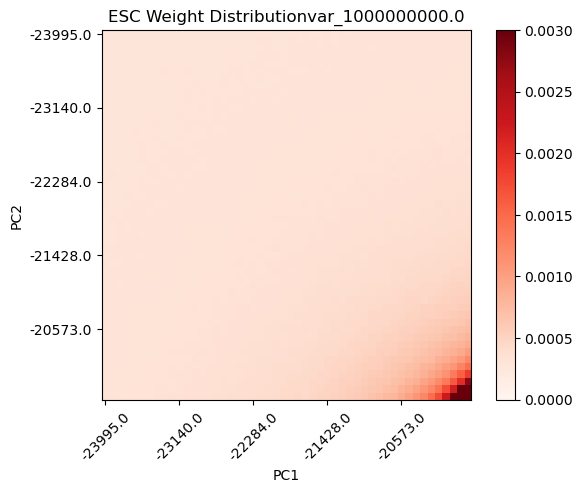

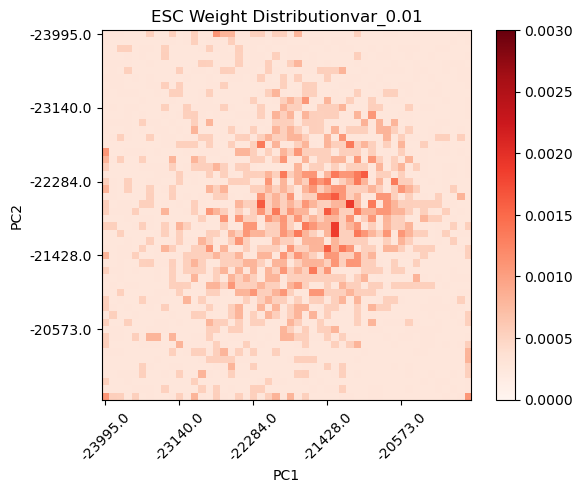

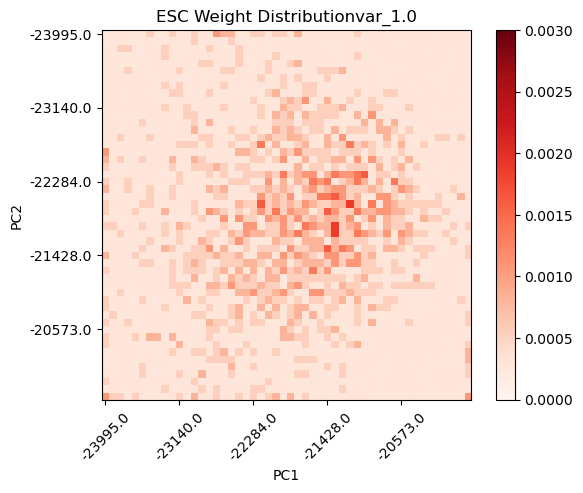

In [22]:
for f in df_dict:
    norm = matplotlib.colors.Normalize(vmin=0, vmax=0.003)
    esc_weights_df = df_dict[f]['ESC']
    fig, ax = plt.subplots()
    contour = ax.imshow( 
                esc_weights_df['weight'].values.reshape(50, 50).T,
                norm=norm,cmap='Reds')
    fig.colorbar(contour, ax=ax)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('ESC Weight Distribution' + f)
    ax.set_xticklabels(labels=np.round(esc_weights_df['PC1'].unique(), 0), rotation=45)
    ax.set_yticklabels(labels=np.round(esc_weights_df['PC2'].unique(), 0))
    fig.savefig(os.path.join(save_dir, 'esc_weight_distribution_imshow_{}.png'.format(f)), dpi=300, bbox_inches='tight')

/tmp/ipykernel_58799/3504800563.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.round(cnc_weights_df['PC1'].unique(), 0), rotation=45)
/tmp/ipykernel_58799/3504800563.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=np.round(cnc_weights_df['PC2'].unique(), 0))


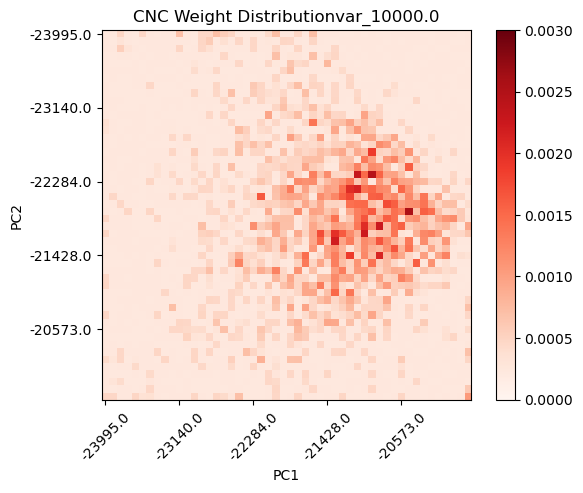

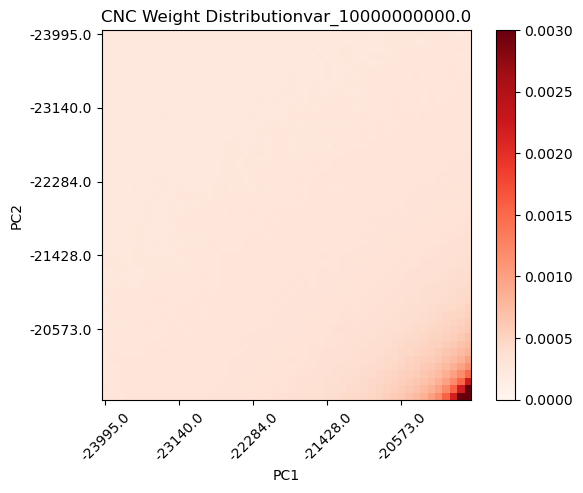

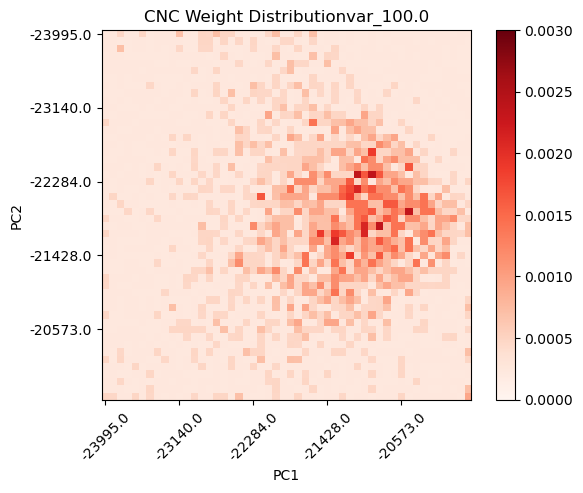

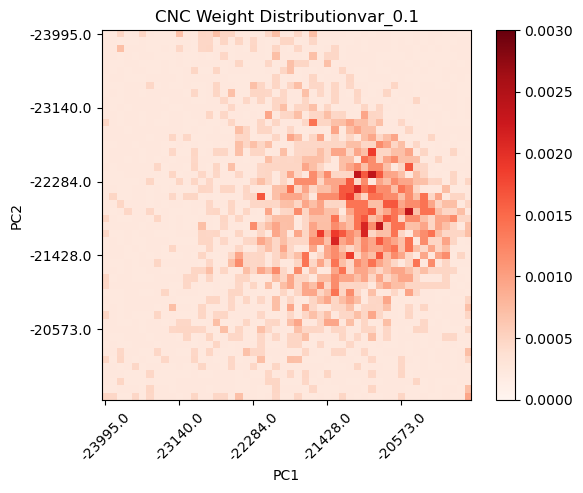

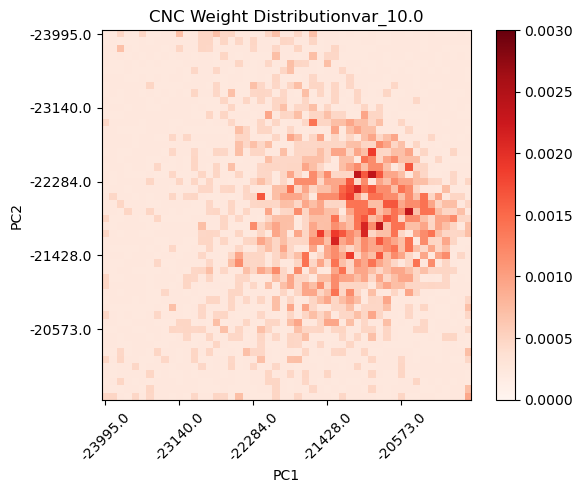

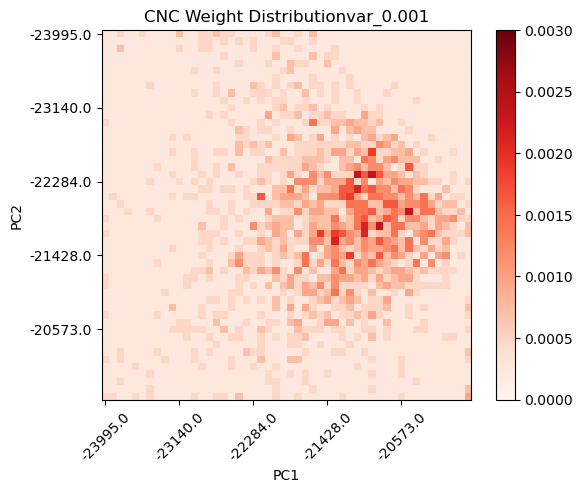

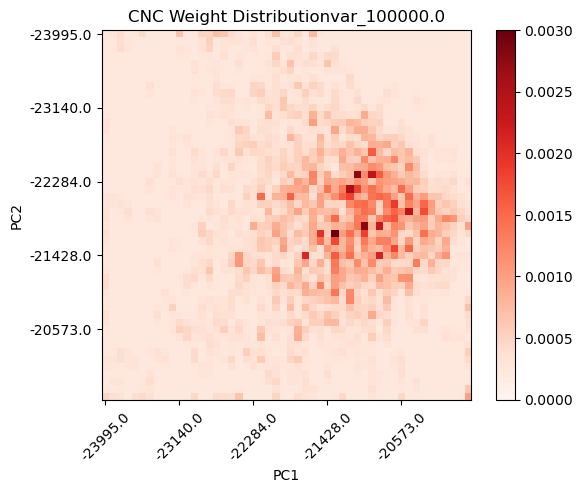

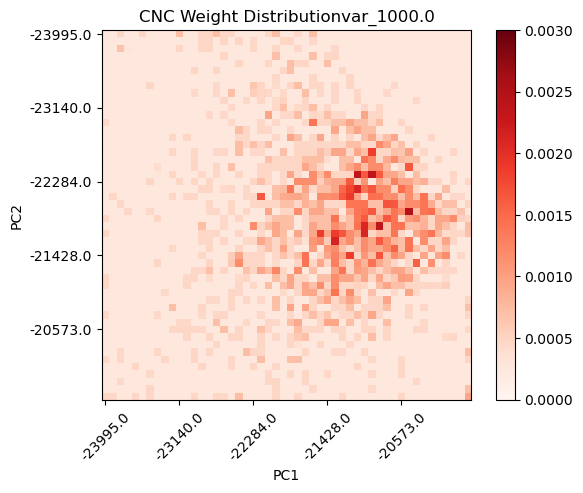

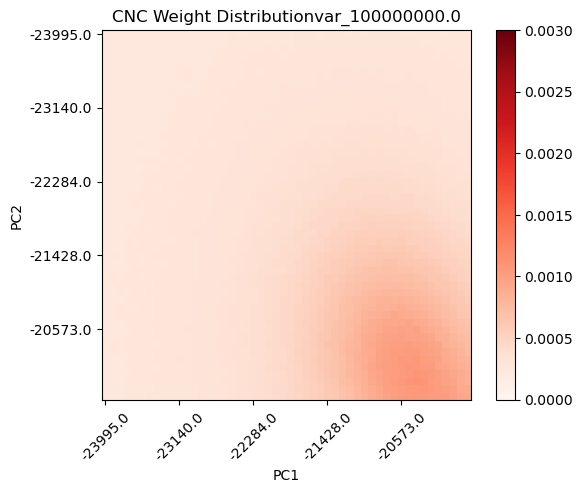

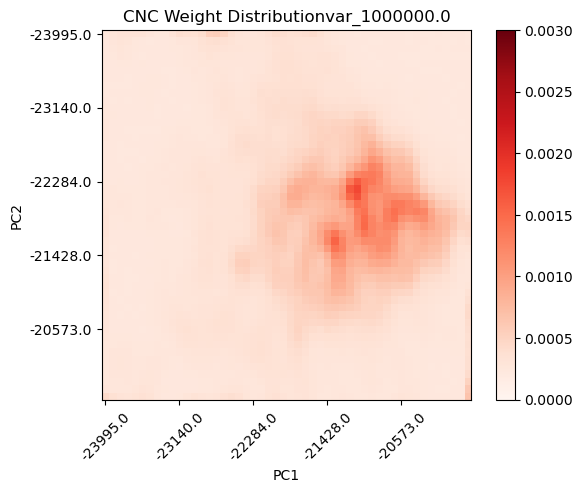

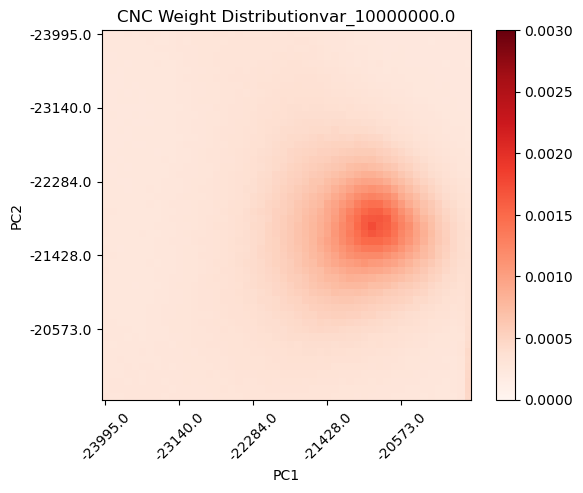

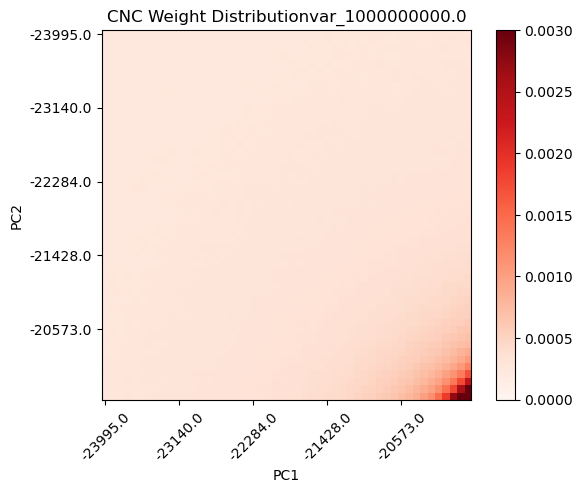

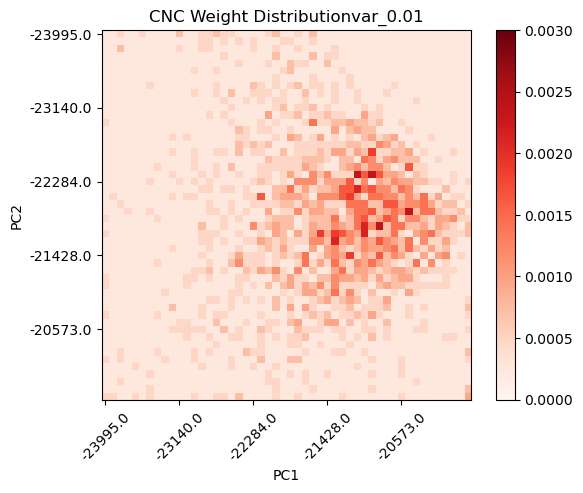

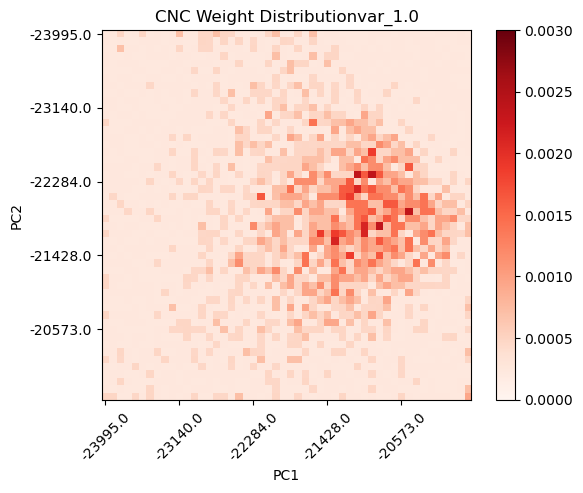

In [23]:
for f in df_dict:
    norm = matplotlib.colors.Normalize(vmin=0, vmax=0.003)
    weights_df = df_dict[f]['CNC']
    fig, ax = plt.subplots()
    contour = ax.imshow( 
                weights_df['weight'].values.reshape(50, 50).T,
                norm=norm,cmap='Reds')
    fig.colorbar(contour, ax=ax)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('CNC Weight Distribution' + f)
    ax.set_xticklabels(labels=np.round(cnc_weights_df['PC1'].unique(), 0), rotation=45)
    ax.set_yticklabels(labels=np.round(cnc_weights_df['PC2'].unique(), 0))
    fig.savefig(os.path.join(save_dir, 'cnc_weight_distribution_imshow_{}.png'.format(f)), dpi=300, bbox_inches='tight')